12 steps to Navier–Stokes
=====
***

In the previous step, we solved the [2D Burgers' equation](./10_Step_8.ipynb): an important equation in the study of fluid mechanics because it contains the full convective nonlinearity of the flow equations. With that exercise, we also build the experience to incrementatlly code a Navier–Stokes solver.

In the next two steps, we will solve Laplace and then Poisson equation. We will then put it all together!

Step 9: 2D Laplace Equation
----
***

Here is Laplace's equation in 2D:

$$\frac{\partial ^2 p}{\partial x^2} + \frac{\partial ^2 p}{\partial y^2} = 0$$

We know how to discretize a 2nd order derivative. But think about this for a minute — Laplace's equation has the features typical of diffusion phenomena. For this reason, it has to be discretized with *central differences*, so that the discretization is consistent with the physics we want to simulate. 

The discretized equation is:

$$\frac{p_{i+1, j}^n - 2p_{i,j}^n + p_{i-1,j}^n}{\Delta x^2} + \frac{p_{i,j+1}^n - 2p_{i,j}^n + p_{i, j-1}^n}{\Delta y^2} = 0$$

Notice that the Laplace Equation does not have a time dependence — there is no $p^{n+1}$.  Instead of tracking a wave through time (like in the previous steps), the Laplace equation calculates the equilibrium state of a system under the supplied boundary conditions.  

If you have taken coursework in Heat Transfer, you will recognize the Laplace Equation as the steady-state heat equation.  

Instead of calculating where the system will be at some time $t$, we will iteratively solve for $p_{i,j}^n$ until it meets a condition that we specify.  The system will reach equilibrium only as the number of iterations tends to $\infty$, but we can approximate the equilibrium state by iterating until the change between one iteration and the next is *very* small.  

Let's rearrange the discretized equation, solving for $p_{i,j}^n$:

$$p_{i,j}^n = \frac{\Delta y^2(p_{i+1,j}^n+p_{i-1,j}^n)+\Delta x^2(p_{i,j+1}^n + p_{i,j-1}^n)}{2(\Delta x^2 + \Delta y^2)}$$

Using second-order central-difference schemes in both directions is the most widely applied method for the Laplace operator. It is also known as the **five-point difference operator**, alluding to its stencil.

We are going to solve Laplace's equation numerically by assuming an initial state of $p=0$ everywhere. Then we add boundary conditions as follows:

$p=0$ at $x=0$

$p=y$ at $x=2$

$\frac{\partial p}{\partial y}=0$ at $y=0, \ 1$

Under these conditions, there is an analytical solution for Laplace's equation:

$$p(x,y)=\frac{x}{4}-4\sum_{n=1,odd}^{\infty}\frac{1}{(n\pi)^2\sinh2n\pi}\sinh n\pi x\cos n\pi y$$

##### Exercise

Write your own code to solve Poisson's equation using loops, in the style of coding used in our first lessons. Then, consider the demonstration of how to write it using functions (below) and modify your code in that style. Can you think of reasons to abandon the old style and adopt modular coding?

Other tips:

+ Visualize each step of the iterative process
+ Think about what the boundary conditions are doing
+ Think about what the PDE is doing

### Using functions

Remember the lesson on writing [functions with Python](./11_Defining_Function_in_Python.ipynb)? We will use that style of code in this exercise.

We're going to define two functions: one that plots our data in a 3D projection plot and the other that iterates to solve for $p$ until the change in the [L1 Norm][1] of $p$ is less than a specified value.   

[1]: http://en.wikipedia.org/wiki/Norm_(mathematics)#Taxicab_norm_or_Manhattan_norm 

In [99]:
using Plots

function plot2D(x, y, p)
    surface(x,y,p,
        colour=:viridis,
        xlims=(0,2),
        ylims=(0,1),
        ylabel="y",
        xlabel="x",
        camera = (30,60)
    )
end

plot2D (generic function with 1 method)

The function `plot2D` takes three arguments, an x-vector, a y-vector and our p matrix.  Given these three values, it produces a 3D projection plot, sets the plot limits and gives us a nice viewing angle.  

$$p_{i,j}^n = \frac{\Delta y^2(p_{i+1,j}^n+p_{i-1,j}^n)+\Delta x^2(p_{i,j+1}^n + p_{i,j-1}^n)}{2(\Delta x^2 + \Delta y^2)}$$

In [86]:
function laplace2D(p, y, Δx, Δy, l1norm_target)
    l1norm = 1
    pⁿ = similar(p)
    
    while l1norm > l1norm_target
        pⁿ = copy(p)
        
        row, col = size(pⁿ)
    
        for j ∈ 1:row
            for i ∈ 1:col
                # Implement boundary conditions
                if i == 1       # @ x = 0, p = 0
                    p[j,i] = 0 
                elseif i == col # @ x = 2 , p=y
                    p[j,i] = y[j]
                elseif j == 1   # @ y = 0, dp/dy = 0
                    p[j,i] == p[j+1,i]
                elseif j == row # @ y = 2, dp/dy = 0
                    p[j,i] = p[j-1,i]
                else
                    # Solve Equation
                    p[j,i] = ((Δy^2*(pⁿ[j,i+1] + pⁿ[j,i-1]) + 
                                Δx^2*(pⁿ[j+1,i] + pⁿ[j-1,i])) / 
                                (2*(Δx^2+Δy^2)))
                end
            end
        end
        # Calculate l1norm of current itteration
        l1norm = sum(abs.(p) - abs.(pⁿ)) / sum(abs.(pⁿ)) 
    end
    return p
end

laplace2D (generic function with 1 method)

`laplace2d` takes five arguments, the `p` matrix, the `y`-vector, `dx`, `dy` and the value `l1norm_target`.  This last value defines how close the `p` matrix should be in two consecutive iterations before the loop breaks and returns the calculated `p` value.  

Note that when executing the cells above in your own notebook, there will be no output.  You have *defined* the function but you have not yet *called* the function.  It is now available for you to use, the same as `numpy.linspace` or any other function in our namespace.  

In [101]:
##variable declarations
nx = 31
ny = 31
c = 1
Δx = 2/(nx-1) 
Δy = 2/(ny-1)

##inital conditions
p = zeros(ny,nx)

x = range(0, stop=2, length=nx)
y = range(0, stop=1, length=ny)

##boundary conditions
p[:, x .== 0] .= 0
p[:, x .== 2] = y
p[y .== 0,:]  = p[2,:]
p[y .== 1,:]  = p[end-1,:];

# The above syntax puts into context the boundary conditions but the notation is a bit messy.
# An alternative syntax is shown below
#p[:, 1] .= 0
#p[:, end] = y
#p[1,:]  = p[2,:]
#p[end,:]  = p[end-1,:]

Now let's try using our `plot2D` function to look at our initial conditions.  If the function has been correctly defined, you should be able to begin typing `plot2D` and hit the **tab** key for auto-complete options.  

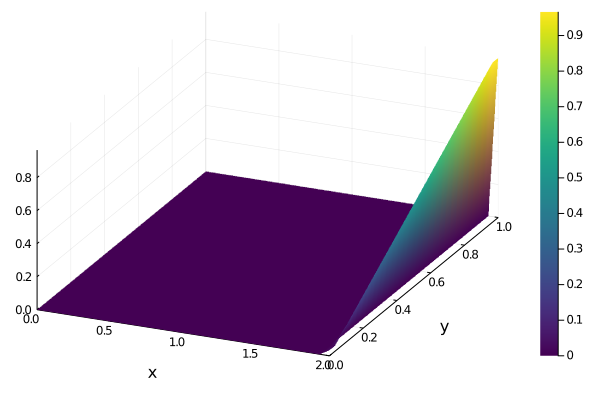

In [102]:
plot2D(x, y, p)

It worked!  This is the initial state of our problem, where the value of `p` is zero everywhere except for along $x=2$ where $p=y$.  Now let's try to run our `laplace2d` function with a specified L1 target of .01

[Hint: if you are having trouble remembering the order in which variables are sent to a function, you can just type `laplace2d(` and the iPython Notebook will put up a little popup box to remind you]

In [104]:
p = laplace2D(p, y, Δx, Δy, 1e-4)

31×31 Array{Float64,2}:
 0.0  0.0          0.0         0.0         …  0.0        0.0        0.0
 0.0  0.000834535  0.00167183  0.00251461     0.0305238  0.0319268  0.0333333
 0.0  0.00166746   0.00334044  0.00502442     0.0610428  0.0638511  0.0666667
 0.0  0.00249715   0.0050026   0.00752459     0.091552   0.0957705  0.1
 0.0  0.00332196   0.00665502  0.0100102      0.122046   0.127682   0.133333
 0.0  0.00414022   0.00829437  0.0124763   …  0.15252    0.159584   0.166667
 0.0  0.00495021   0.00991722  0.0149177      0.182968   0.191473   0.2
 0.0  0.00575017   0.01152     0.0173292      0.213384   0.223345   0.233333
 0.0  0.00653828   0.0130992   0.0197053      0.24376    0.255197   0.266667
 0.0  0.00731264   0.0146509   0.0220403      0.274088   0.287025   0.3
 0.0  0.00807132   0.0161713   0.0243284   …  0.304361   0.318825   0.333333
 0.0  0.00881227   0.0176563   0.0265635      0.334566   0.35059    0.366667
 0.0  0.0095334    0.0191016   0.0287394      0.364693   0.382316   0.

Now try plotting this new value of `p` with our plot function.

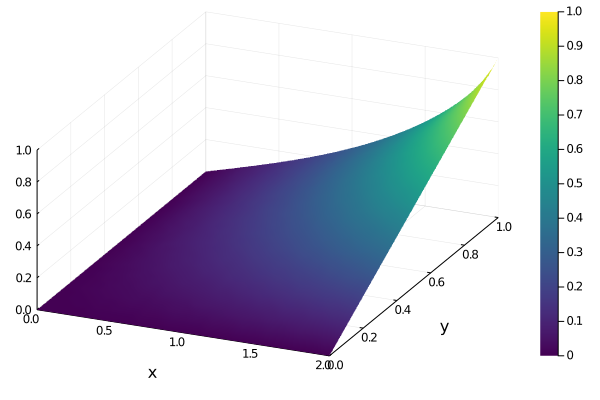

In [105]:
plot2D(x, y, p)

***

## Learn More

The [next step](./13_Step_10.ipynb) will be to solve Poisson's equation. Watch **Video Lesson [11](https://youtube.com/watch?v=ZjfxA3qq2Lg)** on You Tube to understand why we need Poisson's equation in CFD.

And for a detailed walk-through of the discretization of Laplace and Poisson equations (steps 9 and 10), watch **Video Lesson [12](https://youtube.com/watch?v=iwL8ashXhWU)** on You Tube: